## Fit ALS Model

This notebook preps, fits and tunes an ALS model.  The objective is to obtain customer and user factors to be used as features in predictive models

In [1]:
import shutil
import pandas as pd
import numpy as np
import pickle
import boto3
import os
import sys
from sagemaker import get_execution_role
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.sparse as sparse
import csv
import ast

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

!pip install implicit
import implicit

!pip install hyperopt
from hyperopt import hp, Trials, fmin, tpe

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Grocery_Recommender.Run_ALS.data_prep.prep_data_for_ALS import *
from Grocery_Recommender.Run_ALS.train.model import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

     |████████████████████████████████| 1.1MB 3.0MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/4a/1c/6359be64e8301b84160f6f6f7936bbfaaa5e9a4eab6cbc681db07600b949/tqdm-4.45.0-py2.py3-none-any.whl
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3734587 sha256=5c9e72410381445a076eea9784a713c24c7eafb38f3603cafc542e0d66ea308a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 1.9MB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 829kB 53.4MB/s eta 0:00:01
     |████████████████████████████████| 1.7MB 35.1MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491095 sha256=555a868f58494b0c362356307cf9536e8309eb8018fdd91b0f9f16342bc4ea5b
  Stored in directory: /home/ec2-user/.c

In [2]:
role = get_execution_role()
region = boto3.Session().region_name
bucket = "udacity-machine-learning-capstone-data"

### Import the customer transaction file

In [4]:
key = "udacity_capstone_data/all_trans.pkl"
s3 = boto3.client("s3")
trans_pkl = s3.download_file(bucket, key, "./all_trans.pkl")

In [5]:
s3 = boto3.resource("s3")
all_cust_trans = pickle.loads(s3.Bucket(bucket).Object(key).get()["Body"].read())
all_cust_trans.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200607,20060415,7,19,1,0.93,PRD0900033,CL00201,DEP00067,G00021,D00005,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02
1,200607,20060413,5,20,1,1.03,PRD0900097,CL00001,DEP00001,G00001,D00001,CUST0000634693,LA,YF,994100100532898,L,LA,Top Up,Fresh,STORE00001,LS,E02
2,200607,20060416,1,14,1,0.98,PRD0900121,CL00063,DEP00019,G00007,D00002,NaN,NaN,NaN,994100100135562,L,MM,Top Up,Grocery,STORE00001,LS,E02
3,200607,20060415,7,19,1,3.07,PRD0900135,CL00201,DEP00067,G00021,D00005,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02
4,200607,20060415,7,19,1,4.81,PRD0900220,CL00051,DEP00013,G00005,D00002,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02


### Summarize to customer and count of products purchased

Create a DataFrame at the customer and product level with count of the quantity of units purchased as implicit feedback

In [6]:
prep_als = als_data_prep(all_cust_trans, 200716, 200815)

In [7]:
cust_quant_summ = prep_als.create_cust_quant_summ()
cust_quant_summ.head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,1
1,CUST0000000013,PRD0900139,1
2,CUST0000000013,PRD0900161,1
3,CUST0000000013,PRD0900234,3
4,CUST0000000013,PRD0900330,1


### Winsorize the DataFrame to remove outliers

In [8]:
winsorized_list = prep_als.winsorize_df(
    train_df=cust_quant_summ,
    test_df=None,
    valid_df=None,
    cols=["QUANTITY"],
    lower=0.05,
    upper=0.05,
    test_set=False,
    valid_set=False,
)

In [9]:
cust_summ_train = winsorized_list[0]

In [10]:
cust_summ_train.sort_values(["CUST_CODE", "PROD_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,1
1,CUST0000000013,PRD0900139,1
2,CUST0000000013,PRD0900161,1
3,CUST0000000013,PRD0900234,3
4,CUST0000000013,PRD0900330,1


### Normalize the data with a min/max scaler

In [11]:
normalized_list = prep_als.normalize_min_max(
    train_df=cust_summ_train,
    test_df=None,
    valid_df=None,
    group_var="PROD_CODE",
    normal_var="QUANTITY",
    test_set=False,
    valid_set=False,
)

In [12]:
train_df_normal = normalized_list[0]

In [13]:
train_df_normal.sort_values(["CUST_CODE", "PROD_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,0.010000
1856,CUST0000000013,PRD0900139,0.010000
2058,CUST0000000013,PRD0900161,0.010000
2143,CUST0000000013,PRD0900234,0.029231
2657,CUST0000000013,PRD0900330,0.010000


### Remove random rows from each customer to use as a test set

As ALS needs all customers to build the model, random customer/product rows will be held out to use as a test set

In [14]:
test_df, train_df = prep_als.create_als_train_test(train_df_normal, frac=0.1)
test_df.head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000003447,PRD0900121,0.026279
1,CUST0000010712,PRD0900121,0.010000
2,CUST0000010921,PRD0900121,0.010000
3,CUST0000016376,PRD0900121,0.014651
4,CUST0000016975,PRD0900121,0.010000


### Create the index mapping on CUST_CODE and PROD_CODE

The ALS aglorithm requires that the customer vector and product vector be integers - these functions create and merge the mapping

In [15]:
# Create the customer and items mapping files
train_cust_mapping = prep_als.create_mapping(train_df, "CUST_CODE")

In [16]:
train_items_mapping = prep_als.create_mapping(train_df, "PROD_CODE")

In [17]:
train_df_mapped = prep_als.merge_mapping(
    train_df, train_cust_mapping, train_items_mapping
)
train_df_mapped.sort_values(["CUST_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY,index_CUST_CODE,index_PROD_CODE
0,CUST0000000013,PRD0900121,0.010,0,120
6925,CUST0000000013,PRD0903497,0.010,0,3496
4899,CUST0000000013,PRD0902522,0.035,0,2521
3202,CUST0000000013,PRD0901297,0.010,0,1296
5613,CUST0000000013,PRD0902846,0.010,0,2845


In [18]:
test_df_mapped = prep_als.merge_mapping(
    test_df, train_cust_mapping, train_items_mapping
)
test_df_mapped.sort_values(["CUST_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY,index_CUST_CODE,index_PROD_CODE
29036,CUST0000000013,PRD0904158,0.038846,0,4157
11559,CUST0000000013,PRD0900139,0.010000,0,138
29347,CUST0000000013,PRD0902860,0.010000,0,2859
20620,CUST0000000013,PRD0904311,0.010000,0,4310
29755,CUST0000000055,PRD0901006,1.010000,1,1005


### Create the sparse matrix required by ALS

In [19]:
purchases_sparse = prep_als.create_sparse_matrix(train_df_mapped)

In [20]:
purchases_sparse

<4997x4364 sparse matrix of type '<class 'numpy.float64'>'
	with 427908 stored elements in Compressed Sparse Row format>

In [21]:
# Check the sparsity of the matrix
matrix_size = purchases_sparse.shape[0] * purchases_sparse.shape[1]
num_purchases = len(purchases_sparse.nonzero()[0])
sparsity = 100 * (1 - (num_purchases / matrix_size))
sparsity

98.03774106810557

### Hyperparameter tuning

Tune the alpha, number of factors, regularization parameter and number of iterations

In [22]:
# Create the object to fit and tune ALS
als_model = fit_and_tune_als(purchases_sparse)

In [23]:
# Define the search space
space = {
    "alpha": hp.choice("alpha", np.arange(5, 50 + 1, 5, dtype=int)),
    "num_factors": hp.choice("num_factors", np.arange(5, 30 + 1, 5, dtype=int)),
    "reg": hp.choice("reg", np.arange(20, 100 + 1, 1, dtype=int)),
    "iters": hp.choice("iters", np.arange(50, 500 + 1, 1, dtype=int)),
}

In [27]:
best = als_model.tune_params(
    search_space=space,
    out_file="./als_trials.csv",
    max_evals=25,
    train_df=train_df_mapped,
    test_df=test_df_mapped,
)

{'alpha': 30, 'iters': 66, 'num_factors': 20, 'reg': 48}
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

training set mse = 0.03627169453340195, test set mse = 0.03618040960134297
{'alpha': 15, 'iters': 490, 'num_factors': 30, 'reg': 84}                        
  4%|▍         | 1/25 [00:46<18:38, 46.59s/trial, best loss: 0.03618040960134297]

training set mse = 0.029929838769721395, test set mse = 0.030053972420318792     
{'alpha': 40, 'iters': 123, 'num_factors': 30, 'reg': 96}                         
  8%|▊         | 2/25 [02:25<23:51, 62.25s/trial, best loss: 0.030053972420318792]

training set mse = 0.03477960829053879, test set mse = 0.03470095477860223        
{'alpha': 5, 'iters': 308, 'num_factors': 10, 'reg': 60}                          
 12%|█▏        | 3/25 [03:19<21:52, 59.65s/trial, best loss: 0.030053972420318792]

training set mse = 0.032733305700053394, test set mse = 0.032938359186101766      
{'alpha': 15, 'iters': 125, 'num_factors': 15, 'reg': 85}                         
 16%|█▌        | 4/25 [04:22<21:19, 60.91s/trial, best loss: 0.030053972420318792]

training set mse = 0.029929530653460292, test set mse = 0.030055788857266463      
{'alpha': 20, 'iters': 194, 'num_factors': 15, 'reg': 75}                         
 20%|██        | 5/25 [05:17<19:38, 58.91s/trial, best loss: 0.030053972420318792]

training set mse = 0.030325374554388284, test set mse = 0.030353710517152514      
{'alpha': 20, 'iters': 105, 'num_factors': 10, 'reg': 97}                         
 24%|██▍       | 6/25 [06:21<19:07, 60.41s/trial, best loss: 0.030053972420318792]

training set mse = 0.029759712243755645, test set mse = 0.029835973223929838      
{'alpha': 5, 'iters': 59, 'num_factors': 20, 'reg': 82}                           
 28%|██▊       | 7/25 [07:10<17:11, 57.29s/trial, best loss: 0.029835973223929838]

training set mse = 0.03362193346548751, test set mse = 0.03383080120619972        
{'alpha': 40, 'iters': 165, 'num_factors': 20, 'reg': 36}                         
 32%|███▏      | 8/25 [07:55<15:07, 53.39s/trial, best loss: 0.029835973223929838]

training set mse = 0.04310676834296971, test set mse = 0.04290550024258016        
{'alpha': 5, 'iters': 121, 'num_factors': 10, 'reg': 94}                          
 36%|███▌      | 9/25 [08:52<14:33, 54.57s/trial, best loss: 0.029835973223929838]

training set mse = 0.033925599262011476, test set mse = 0.0341354271229482        
{'alpha': 15, 'iters': 56, 'num_factors': 30, 'reg': 75}                           
 40%|████      | 10/25 [09:39<13:02, 52.15s/trial, best loss: 0.029835973223929838]

training set mse = 0.02996604421075266, test set mse = 0.030068370802880325        
{'alpha': 25, 'iters': 354, 'num_factors': 30, 'reg': 82}                          
 44%|████▍     | 11/25 [10:24<11:41, 50.08s/trial, best loss: 0.029835973223929838]

training set mse = 0.030975688679626447, test set mse = 0.030992029860445216       
{'alpha': 10, 'iters': 332, 'num_factors': 5, 'reg': 51}                           
 48%|████▊     | 12/25 [11:46<12:56, 59.70s/trial, best loss: 0.029835973223929838]

training set mse = 0.030549621541388607, test set mse = 0.030689159811745657       
{'alpha': 25, 'iters': 333, 'num_factors': 10, 'reg': 37}                          
 52%|█████▏    | 13/25 [12:59<12:45, 63.80s/trial, best loss: 0.029835973223929838]

training set mse = 0.0344791338576603, test set mse = 0.03431656305570683          
{'alpha': 15, 'iters': 258, 'num_factors': 10, 'reg': 35}                          
 56%|█████▌    | 14/25 [14:14<12:18, 67.14s/trial, best loss: 0.029835973223929838]

training set mse = 0.031371743395487414, test set mse = 0.031353746412157456       
{'alpha': 30, 'iters': 441, 'num_factors': 15, 'reg': 29}                          
 60%|██████    | 15/25 [15:23<11:15, 67.51s/trial, best loss: 0.029835973223929838]

training set mse = 0.03862435292018019, test set mse = 0.038492265364709406        
{'alpha': 10, 'iters': 485, 'num_factors': 25, 'reg': 27}                          
 64%|██████▍   | 16/25 [16:55<11:14, 74.98s/trial, best loss: 0.029835973223929838]

training set mse = 0.031493649152317275, test set mse = 0.03158991968487608        
{'alpha': 40, 'iters': 407, 'num_factors': 10, 'reg': 96}                          
 68%|██████▊   | 17/25 [18:35<10:59, 82.49s/trial, best loss: 0.029835973223929838]

training set mse = 0.03527269104278084, test set mse = 0.03511539756268442         
{'alpha': 10, 'iters': 434, 'num_factors': 15, 'reg': 45}                          
 72%|███████▏  | 18/25 [19:58<09:38, 82.63s/trial, best loss: 0.029835973223929838]

training set mse = 0.030624690197687092, test set mse = 0.03072411786365437        
{'alpha': 20, 'iters': 317, 'num_factors': 25, 'reg': 99}                          
 76%|███████▌  | 19/25 [21:31<08:34, 85.75s/trial, best loss: 0.029835973223929838]

training set mse = 0.029732345382252907, test set mse = 0.02981395450112164        
{'alpha': 20, 'iters': 102, 'num_factors': 25, 'reg': 99}                          
 80%|████████  | 20/25 [22:49<06:56, 83.28s/trial, best loss: 0.02981395450112164]

training set mse = 0.029732755328155648, test set mse = 0.02981407767487767       
{'alpha': 45, 'iters': 415, 'num_factors': 25, 'reg': 63}                         
 84%|████████▍ | 21/25 [23:40<04:54, 73.72s/trial, best loss: 0.02981395450112164]

training set mse = 0.041133498591721905, test set mse = 0.04102108093165262       
{'alpha': 50, 'iters': 317, 'num_factors': 25, 'reg': 99}                         
 88%|████████▊ | 22/25 [25:10<03:56, 78.72s/trial, best loss: 0.02981395450112164]

training set mse = 0.03866753718527553, test set mse = 0.03851370044644811        
{'alpha': 20, 'iters': 312, 'num_factors': 25, 'reg': 79}                         
 92%|█████████▏| 23/25 [26:28<02:36, 78.46s/trial, best loss: 0.02981395450112164]

training set mse = 0.030149847631076414, test set mse = 0.0302042021320837        
{'alpha': 35, 'iters': 207, 'num_factors': 25, 'reg': 99}                         
 96%|█████████▌| 24/25 [27:46<01:18, 78.13s/trial, best loss: 0.02981395450112164]

training set mse = 0.03289550930960691, test set mse = 0.032838726844795045       
100%|██████████| 25/25 [28:50<00:00, 69.21s/trial, best loss: 0.02981395450112164]


In [28]:
results = pd.read_csv("./als_trials.csv")

# Sort with best scores on top and reset index for slicing
results.sort_values("loss", ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)
results.head()

,loss,params,iteration,train_time,status
0,0.029814,"{'alpha': 20, 'iters': 317, 'num_factors': 25,...",20,77.472350,ok
1,0.029814,"{'alpha': 20, 'iters': 102, 'num_factors': 25,...",21,51.367907,ok
2,0.029836,"{'alpha': 20, 'iters': 105, 'num_factors': 10,...",7,49.947693,ok
3,0.030054,"{'alpha': 15, 'iters': 490, 'num_factors': 30,...",2,98.720767,ok
4,0.030056,"{'alpha': 15, 'iters': 125, 'num_factors': 15,...",5,54.183241,ok


In [29]:
best_params = ast.literal_eval(results.loc[0, "params"]).copy()
best_params

{'alpha': 20, 'iters': 317, 'num_factors': 25, 'reg': 99}

### Visualize the hyperparameter search

In [30]:
bayes_params = pd.DataFrame(
    columns=list(ast.literal_eval(results.loc[0, "params"]).keys()),
    index=list(range(len(results))),
)

# Add the results with each parameter a different column
for i, params in enumerate(results["params"]):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())

bayes_params["loss"] = results["loss"]
bayes_params["iteration"] = results["iteration"]

bayes_params.head()

,alpha,iters,num_factors,reg,loss,iteration
0,20,317,25,99,0.029814,20
1,20,102,25,99,0.029814,21
2,20,105,10,97,0.029836,7
3,15,490,30,84,0.030054,2
4,15,125,15,85,0.030056,5


Text(0.5, 1.0, 'Regularization Parameter Search Distribution')

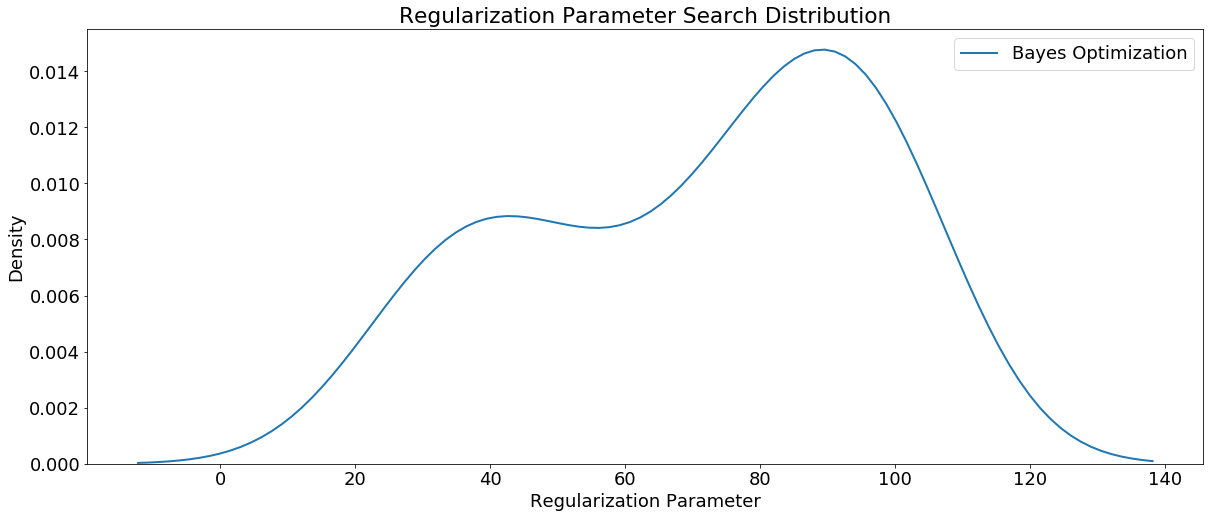

In [31]:
plt.figure(figsize=(20, 8))
plt.rcParams["font.size"] = 18

# Density plots of the learning rate distributions
sns.kdeplot(bayes_params["reg"], label="Bayes Optimization", linewidth=2)
plt.xlabel("Regularization Parameter")
plt.ylabel("Density")
plt.title("Regularization Parameter Search Distribution")

Text(0.5, 1.0, 'Regularization Parameter Search Distribution')

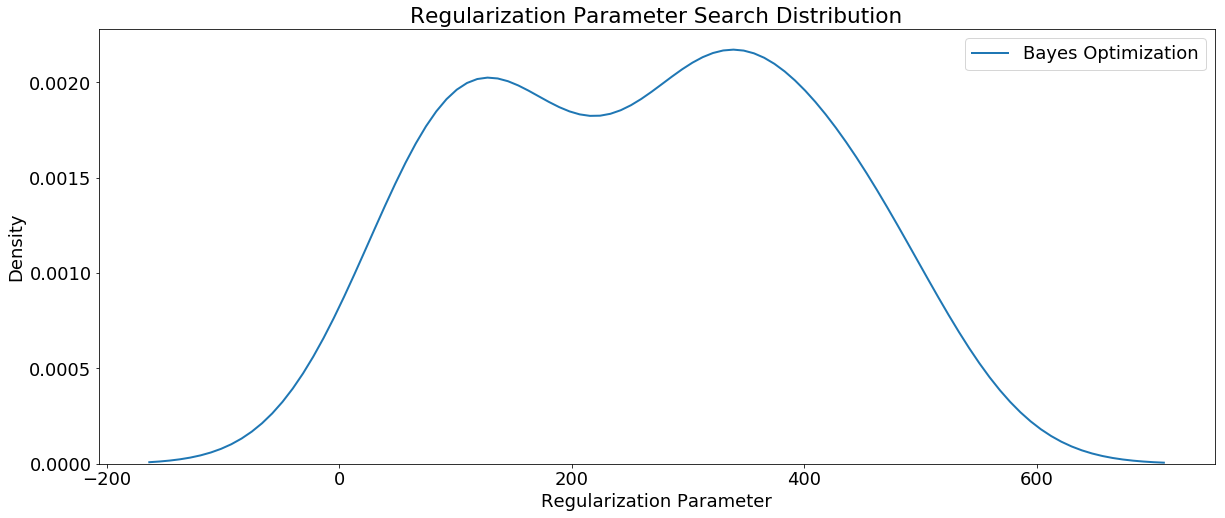

In [32]:
plt.figure(figsize=(20, 8))
plt.rcParams["font.size"] = 18

sns.kdeplot(bayes_params["iters"], label="Bayes Optimization", linewidth=2)
plt.xlabel("Regularization Parameter")
plt.ylabel("Density")
plt.title("Regularization Parameter Search Distribution")

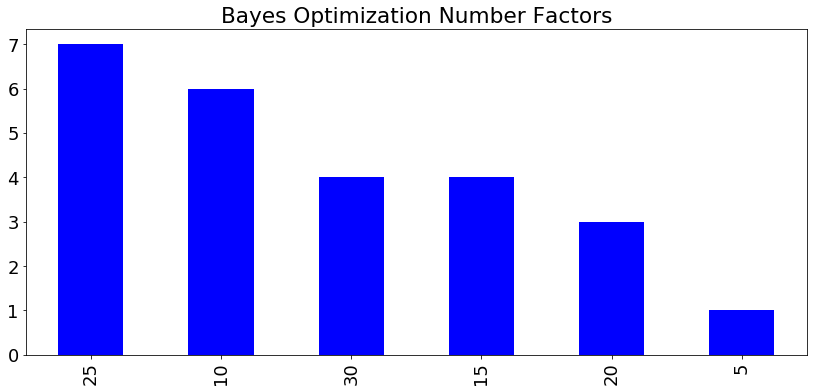

In [33]:
bayes_params["num_factors"].value_counts().plot.bar(
    figsize=(14, 6), color="blue", title="Bayes Optimization Number Factors"
)

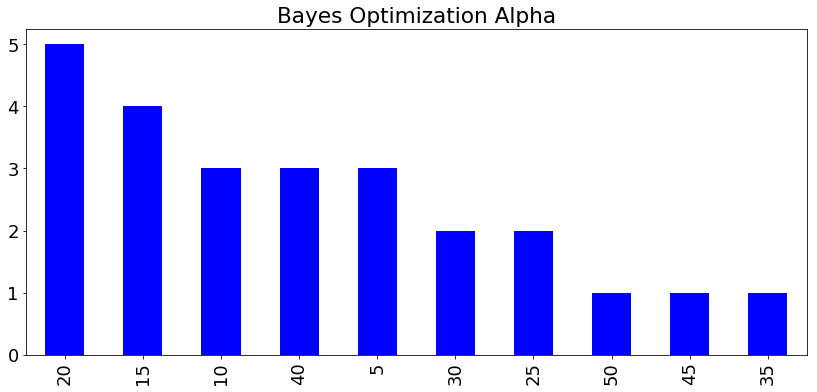

In [34]:
bayes_params["alpha"].value_counts().plot.bar(
    figsize=(14, 6), color="blue", title="Bayes Optimization Alpha"
)

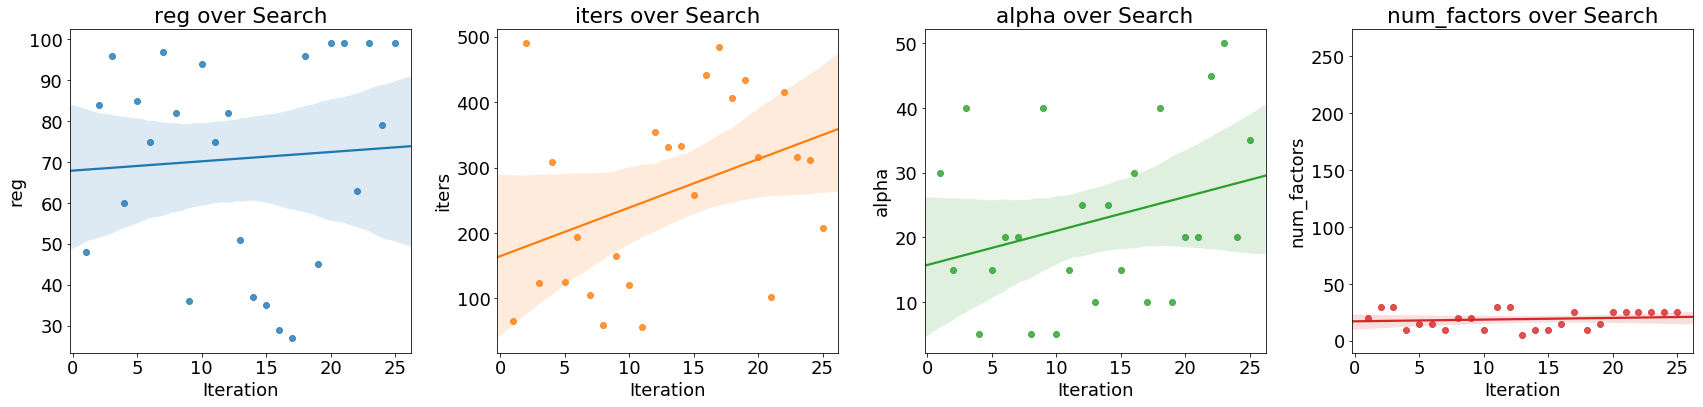

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(["reg", "iters", "alpha", "num_factors"]):
    # Scatterplot
    sns.regplot("iteration", hyper, data=bayes_params, ax=axs[i])
    axs[i].set(
        xlabel="Iteration",
        ylabel="{}".format(hyper),
        title="{} over Search".format(hyper),
    )

plt.tight_layout()

Text(0.5, 1.0, 'Bayes Optimization MSE')

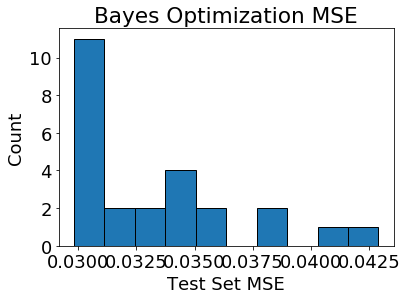

In [36]:
plt.hist(bayes_params["loss"], label="Bayes Optimization", edgecolor="k")
plt.xlabel("Test Set MSE")
plt.ylabel("Count")
plt.title("Bayes Optimization MSE")

Text(0.5, 1.0, 'Test Set MSE versus Iteration')

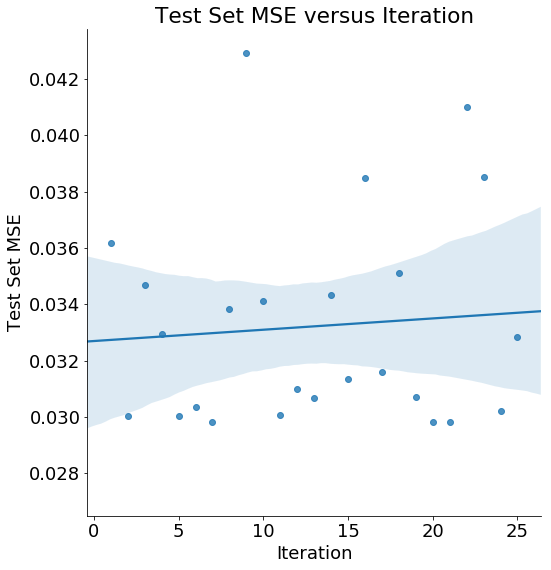

In [37]:
# Plot of scores over the course of searching
sns.lmplot("iteration", "loss", data=bayes_params, size=8)
plt.xlabel("Iteration")
plt.ylabel("Test Set MSE")
plt.title("Test Set MSE versus Iteration")

In [39]:
# Save dataframes of parameters
bayes_params.to_csv("./bayes_params.csv", index=False)

### Fit the ALS model with tuned parameters

Fit the ALS model and return the user and item vectors

In [40]:
best_model, user_vecs, item_vecs = als_model.fit_als(
    alpha=best_params["alpha"],
    num_factors=best_params["num_factors"],
    reg=best_params["reg"],
    iters=best_params["iters"],
)

### Get the MSE on the training and test sets

In [41]:
training_mse, test_set_mse = als_model.get_mse(
    user_vecs, item_vecs, train_df_mapped, test_df_mapped
)

training set mse = 0.029732382036385934, test set mse = 0.029813962653666676


### Convert user and item vectors to DataFrame and map to CUST_CODE and PROD_CODE

In [42]:
user_factors, item_factors = als_model.get_user_item_factors(
    user_vecs, item_vecs, train_df_mapped, train_items_mapping, train_cust_mapping
)

In [43]:
user_factors.head()

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18,factor_19,factor_20,factor_21,factor_22,factor_23,factor_24,CUST_CODE
0,0.007463,-0.000680,0.005366,0.003615,0.004651,0.003823,0.005890,0.007055,0.006187,0.004056,0.007359,0.002281,0.004601,0.004757,0.004688,0.005582,0.006605,0.006112,0.005509,0.005362,0.006187,0.000481,0.003822,0.004832,0.003206,CUST0000000013
1,0.042196,-0.006041,0.006751,-0.007820,0.062753,-0.020122,0.018090,-0.000979,0.029097,-0.038228,0.079624,-0.009766,0.036663,0.007683,0.063245,0.061379,0.058113,0.048389,0.083416,0.059592,0.054784,-0.020142,0.102031,0.047736,0.001445,CUST0000000055
2,0.001905,0.007551,0.002333,0.007438,0.000220,0.008861,0.001843,0.004826,-0.000733,0.002802,0.000451,0.004297,-0.003757,0.004145,-0.002075,0.006993,0.007711,0.004604,0.005062,0.003206,0.004965,0.005310,-0.000805,0.004205,0.002555,CUST0000000679
3,0.000266,0.000624,0.001455,0.002870,0.001215,0.006305,0.001464,0.002308,-0.000875,0.001824,0.002093,0.000443,-0.000591,0.003088,-0.000442,0.003117,0.003052,0.003245,0.004089,0.002015,0.003788,0.003661,-0.000552,-0.000080,-0.000126,CUST0000001052
4,0.004335,0.003057,0.002655,-0.000290,0.004878,-0.000792,0.002543,0.001441,0.002682,0.000621,0.004846,0.002609,0.005400,0.003539,0.004997,0.002581,0.002828,0.002913,0.004326,0.002815,0.005709,0.001710,0.008268,0.003413,0.002465,CUST0000001058


In [44]:
item_factors.head()

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18,factor_19,factor_20,factor_21,factor_22,factor_23,factor_24,PROD_CODE
0,0.098852,0.163831,0.062782,0.116470,0.209002,0.200804,0.083324,0.114422,-0.001722,0.071923,0.135773,0.118632,0.134937,0.171609,0.075134,0.157838,0.163906,0.148084,0.203248,0.127189,0.243155,0.173337,0.178632,0.115693,0.043675,PRD0900121
1,0.058094,0.030093,0.059018,0.007452,0.035343,0.005170,0.048432,0.027936,0.046388,0.036067,0.040936,0.036383,0.055214,0.051103,0.049959,0.026097,0.027814,0.030770,0.034937,0.012814,0.044953,0.028312,0.059118,0.032478,0.043089,PRD0900161
2,0.000766,0.023513,0.026635,0.033137,0.004971,0.049122,0.014308,0.023726,0.000620,0.038399,0.003672,0.024392,0.004450,0.027772,-0.000906,0.011066,0.013943,0.017316,0.012777,0.016307,0.021514,0.043878,-0.008592,0.001315,0.019906,PRD0900234
3,0.010650,0.004709,0.026922,0.017818,0.005461,0.010362,0.018078,0.009987,0.013994,0.022470,0.007272,0.003001,0.006082,0.012889,0.008665,0.009801,0.004736,0.007354,0.011249,0.008088,-0.004738,0.008003,-0.008687,0.001506,0.011334,PRD0900330
4,0.060486,0.002112,-0.015682,0.022759,0.105784,0.003024,0.022878,0.019869,0.026967,-0.037187,0.104706,0.011538,0.054761,-0.003606,0.055310,0.095097,0.086594,0.073725,0.097978,0.106644,0.083489,-0.036869,0.109061,0.088064,-0.007758,PRD0900434


In [48]:
# Upload user and item factors to s3

item_factors.to_csv("./item_factors.csv", index=False)
key = "item_factors.csv"  # filepath in s3
s3.Bucket(bucket).Object(key).upload_file("./item_factors.csv")

user_factors.to_csv("./user_factors.csv", index=False)
key = "user_factors.csv"  # filepath in s3
s3.Bucket(bucket).Object(key).upload_file("./user_factors.csv")

### Create DataFrame of predicitions

In [49]:
predictions = als_model.predict(user_vecs, item_vecs, train_df_mapped, 1000)
predictions.head()

,PRED_QUANTITY,pred_rank,CUST_CODE,PROD_CODE
0,0.015402,43.0,CUST0000000013,PRD0900121
1,0.115589,46.0,CUST0000000055,PRD0900121
2,0.012860,31.0,CUST0000000679,PRD0900121
3,0.007348,29.0,CUST0000001052,PRD0900121
4,0.011222,35.0,CUST0000001058,PRD0900121


In [50]:
# Upload the predictions file to s3
predictions.to_csv("predictions.csv")
key = "predictions.csv"  # filepath in s3
s3.Bucket(bucket).Object(key).upload_file("predictions.csv")